# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

# Laboratório 14: Transfer Learning

## Importações e Configurações

In [1]:
import os
import torch
import zipfile
import requests
import numpy as np
import torch.nn as nn
from PIL import Image
from io import BytesIO
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Dados

In [2]:
if not os.path.exists('data/hymenoptera_data'):
    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
    response = requests.get(url)
    with zipfile.ZipFile(BytesIO(response.content)) as z:
        z.extractall("data/hymenoptera_data")
    print("Dataset 'hymenoptera_data' baixado e extraído.")
else:
    print("Dataset 'hymenoptera_data' já existe.")

Dataset 'hymenoptera_data' baixado e extraído.


In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        self.data = []
        for class_name in self.class_names:
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(class_dir, filename)
                    item = (path, self.class_to_idx[class_name])
                    self.data.append(item)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data/hymenoptera_data'

# Criando instâncias de Dataset
train_dataset = CustomImageDataset(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = CustomImageDataset(os.path.join(data_dir, 'val'), data_transforms['val'])

# Criando instâncias de DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

# Obtendo informações
class_names = train_dataset.class_names
train_size = len(train_dataset)
val_size = len(val_dataset)

print(f"Classes: {class_names}")
print(f"Tamanho do dataset de treino: {train_size}")
print(f"Tamanho do dataset de validação: {val_size}")

Classes: ['ants', 'bees']
Tamanho do dataset de treino: 244
Tamanho do dataset de validação: 153


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Funções auxiliares

In [6]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        for phase, loader in [('train', train_loader), ('val', val_loader)]:
            model.train(phase == 'train')
            running_loss, running_corrects = 0.0, 0
            size = len(loader.dataset)

            loop = tqdm(loader, desc=f'{phase.capitalize()}')
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / size
            epoch_acc = running_corrects.double() / size
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    return history

In [7]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

## Modelo Baseline

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [9]:
# Movendo o modelo para o device
baseline_model = SimpleCNN().to(device)

# Otimizador e função de perda
criterion = nn.CrossEntropyLoss()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=0.001)

In [10]:
# Treinando o modelo
history_baseline = train_model(
    baseline_model, criterion, optimizer_baseline, train_dataloader, val_dataloader, num_epochs=25
)


Epoch 1/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 1.7556 Acc: 0.5287


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.8332 Acc: 0.4771

Epoch 2/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6599 Acc: 0.5984


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6571 Acc: 0.6340

Epoch 3/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6276 Acc: 0.6270


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6476 Acc: 0.6340

Epoch 4/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5938 Acc: 0.6598


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.8743 Acc: 0.5425

Epoch 5/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6033 Acc: 0.6844


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6429 Acc: 0.6209

Epoch 6/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6165 Acc: 0.6270


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6537 Acc: 0.6209

Epoch 7/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6178 Acc: 0.6721


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6786 Acc: 0.6013

Epoch 8/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6111 Acc: 0.6475


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6675 Acc: 0.6013

Epoch 9/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6124 Acc: 0.6557


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6559 Acc: 0.6471

Epoch 10/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5680 Acc: 0.6844


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6406 Acc: 0.6471

Epoch 11/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5637 Acc: 0.7090


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6179 Acc: 0.6601

Epoch 12/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5872 Acc: 0.6762


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6713 Acc: 0.6275

Epoch 13/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5655 Acc: 0.7213


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.8675 Acc: 0.6732

Epoch 14/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5751 Acc: 0.6803


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6940 Acc: 0.6667

Epoch 15/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5624 Acc: 0.6762


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6385 Acc: 0.7059

Epoch 16/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5310 Acc: 0.7828


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.5600 Acc: 0.7255

Epoch 17/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6100 Acc: 0.7295


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.5859 Acc: 0.6732

Epoch 18/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5654 Acc: 0.7131


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6337 Acc: 0.6471

Epoch 19/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5205 Acc: 0.7541


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6343 Acc: 0.6863

Epoch 20/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5209 Acc: 0.7377


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.5870 Acc: 0.7255

Epoch 21/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5382 Acc: 0.7459


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.6791 Acc: 0.6405

Epoch 22/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4750 Acc: 0.7500


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.5466 Acc: 0.7190

Epoch 23/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5243 Acc: 0.7582


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.5632 Acc: 0.7190

Epoch 24/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5129 Acc: 0.7746


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.5510 Acc: 0.7190

Epoch 25/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4812 Acc: 0.7746


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.5868 Acc: 0.7190


# Exercícios

## Exercício 1

Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [11]:
# Carregando o modelo ResNet-50 pré-treinado
resnet50_pretrained  = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Congelando todos os parâmetros
for param in resnet50_pretrained.parameters():
    param.requires_grad = False

# Substituindo a camada final
numero_de_features = resnet50_pretrained.fc.in_features
resnet50_pretrained.fc = nn.Linear(numero_de_features, len(class_names))

# Descongelando o último bloco convolucional
for param in resnet50_pretrained.layer4.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


In [12]:
resnet50_pretrained = resnet50_pretrained.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_resnet50 = optim.Adam([
    {'params': resnet50_pretrained.fc.parameters(), 'lr': 1e-3},      # LR alto para a nova camada (que substituiu a final)
    {'params': resnet50_pretrained.layer4.parameters(), 'lr': 1e-5}  # LR baixo para a layer4
], lr=1e-3) # LR padrão

In [13]:
history_resnet50 = train_model(
    resnet50_pretrained, criterion, optimizer_resnet50, train_dataloader, val_dataloader, num_epochs=25
)


Epoch 1/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.5855 Acc: 0.7213


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.3661 Acc: 0.9477

Epoch 2/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4263 Acc: 0.8197


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2440 Acc: 0.9608

Epoch 3/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3768 Acc: 0.8525


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1891 Acc: 0.9477

Epoch 4/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3077 Acc: 0.8689


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1624 Acc: 0.9542

Epoch 5/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2243 Acc: 0.9262


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1327 Acc: 0.9739

Epoch 6/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2957 Acc: 0.8730


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1302 Acc: 0.9739

Epoch 7/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.1991 Acc: 0.9180


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1185 Acc: 0.9673

Epoch 8/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2298 Acc: 0.9057


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1137 Acc: 0.9673

Epoch 9/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2041 Acc: 0.9016


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1157 Acc: 0.9673

Epoch 10/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2330 Acc: 0.9016


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1075 Acc: 0.9608

Epoch 11/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2014 Acc: 0.9303


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1100 Acc: 0.9804

Epoch 12/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.1496 Acc: 0.9508


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.0825 Acc: 0.9673

Epoch 13/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2397 Acc: 0.9221


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1012 Acc: 0.9673

Epoch 14/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2401 Acc: 0.9016


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1126 Acc: 0.9608

Epoch 15/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2299 Acc: 0.8975


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1093 Acc: 0.9673

Epoch 16/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.1800 Acc: 0.9221


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1275 Acc: 0.9412

Epoch 17/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.1384 Acc: 0.9467


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1060 Acc: 0.9673

Epoch 18/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2503 Acc: 0.8648


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1127 Acc: 0.9673

Epoch 19/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.1578 Acc: 0.9508


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1156 Acc: 0.9673

Epoch 20/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.1821 Acc: 0.9303


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.0953 Acc: 0.9804

Epoch 21/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.1413 Acc: 0.9590


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1189 Acc: 0.9739

Epoch 22/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.1752 Acc: 0.9303


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.0879 Acc: 0.9804

Epoch 23/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.2134 Acc: 0.9180


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.0990 Acc: 0.9804

Epoch 24/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.1557 Acc: 0.9385


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.0852 Acc: 0.9739

Epoch 25/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.1787 Acc: 0.9180


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.0907 Acc: 0.9804


## Exercício 2

Escolha outro modelo pré-treinado em [Torchvision Models](https://docs.pytorch.org/vision/main/models.html) e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [14]:
googlenet_pretrained = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

for param in googlenet_pretrained.parameters():
    param.requires_grad = False

numero_de_features = googlenet_pretrained.fc.in_features
googlenet_pretrained.fc = nn.Linear(numero_de_features, len(class_names))

for param in googlenet_pretrained.inception5b.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 170MB/s]


In [15]:
googlenet_pretrained = googlenet_pretrained.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam([
    {'params': googlenet_pretrained.fc.parameters(), 'lr': 1e-3},
    {'params': googlenet_pretrained.inception5b.parameters(), 'lr': 1e-5}
], lr=1e-3)

In [16]:
history_googlenet = train_model(
    googlenet_pretrained, criterion, optimizer_googlenet, train_dataloader, val_dataloader, num_epochs=25
)


Epoch 1/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.6401 Acc: 0.5943


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.3951 Acc: 0.9085

Epoch 2/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4772 Acc: 0.7746


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2893 Acc: 0.9346

Epoch 3/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4104 Acc: 0.8279


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2647 Acc: 0.9281

Epoch 4/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4349 Acc: 0.8197


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2254 Acc: 0.9281

Epoch 5/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4295 Acc: 0.7787


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2191 Acc: 0.9281

Epoch 6/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3940 Acc: 0.8197


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2088 Acc: 0.9412

Epoch 7/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4223 Acc: 0.8238


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2029 Acc: 0.9281

Epoch 8/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3808 Acc: 0.8320


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2011 Acc: 0.9281

Epoch 9/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3309 Acc: 0.8320


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2055 Acc: 0.9281

Epoch 10/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4426 Acc: 0.7869


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2280 Acc: 0.9412

Epoch 11/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4025 Acc: 0.8361


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1989 Acc: 0.9412

Epoch 12/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4108 Acc: 0.8238


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2051 Acc: 0.9281

Epoch 13/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4017 Acc: 0.8115


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2258 Acc: 0.9150

Epoch 14/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4157 Acc: 0.8115


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1904 Acc: 0.9346

Epoch 15/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4205 Acc: 0.8361


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2195 Acc: 0.9281

Epoch 16/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4198 Acc: 0.8484


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2175 Acc: 0.9216

Epoch 17/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4326 Acc: 0.7787


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2124 Acc: 0.9281

Epoch 18/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3913 Acc: 0.8197


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2288 Acc: 0.9346

Epoch 19/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3768 Acc: 0.8402


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1944 Acc: 0.9346

Epoch 20/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4274 Acc: 0.8033


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1881 Acc: 0.9412

Epoch 21/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3486 Acc: 0.8320


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1897 Acc: 0.9412

Epoch 22/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3206 Acc: 0.8525


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2006 Acc: 0.9281

Epoch 23/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3827 Acc: 0.8402


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.1807 Acc: 0.9281

Epoch 24/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.3156 Acc: 0.8689


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2174 Acc: 0.9477

Epoch 25/25


Train:   0%|          | 0/61 [00:00<?, ?it/s]

Train Loss: 0.4759 Acc: 0.7787


Val:   0%|          | 0/39 [00:00<?, ?it/s]

Val Loss: 0.2245 Acc: 0.9281


## Comparação dos Plots

Plots Baseline


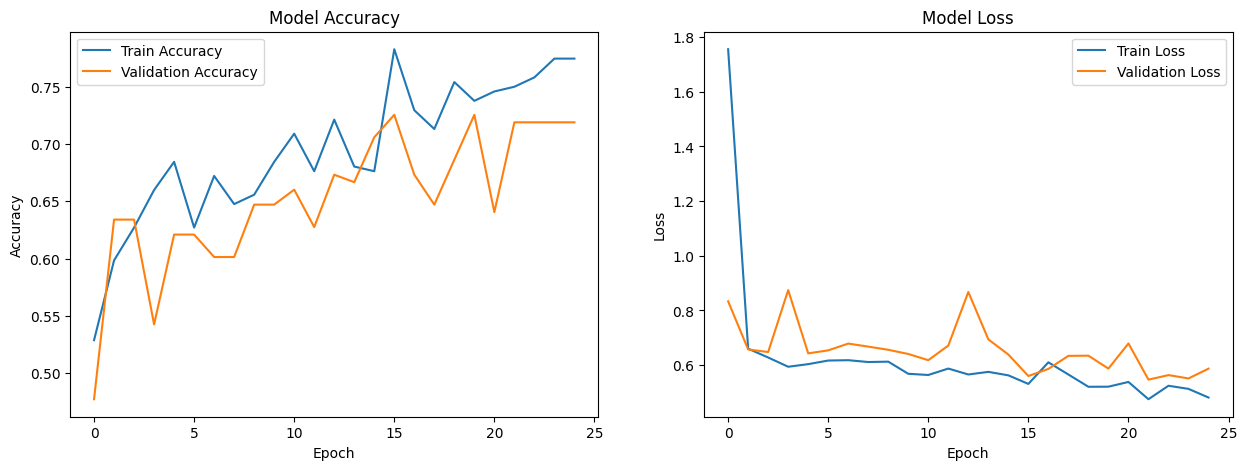

Plots ResNet50


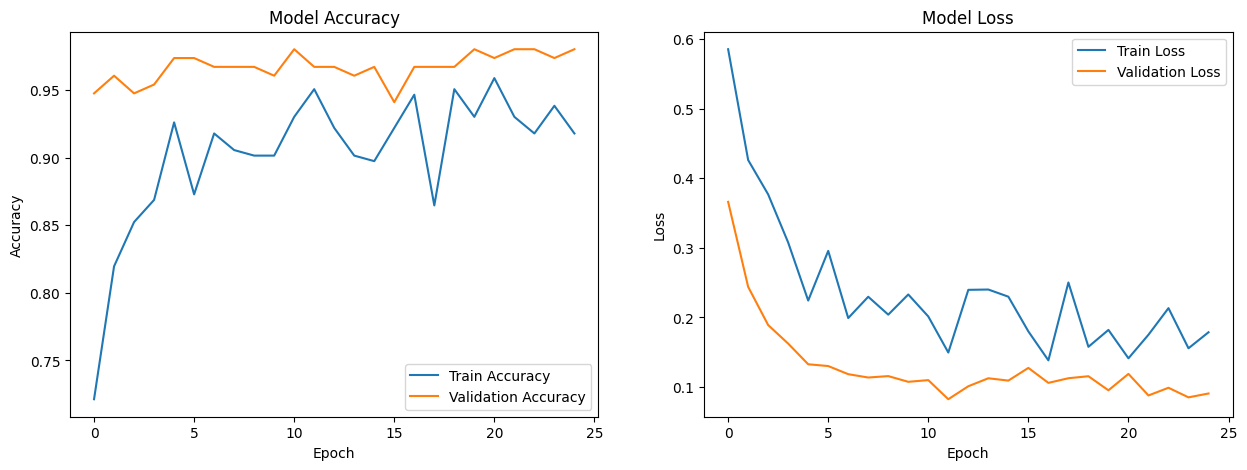

Plots GoogleNet


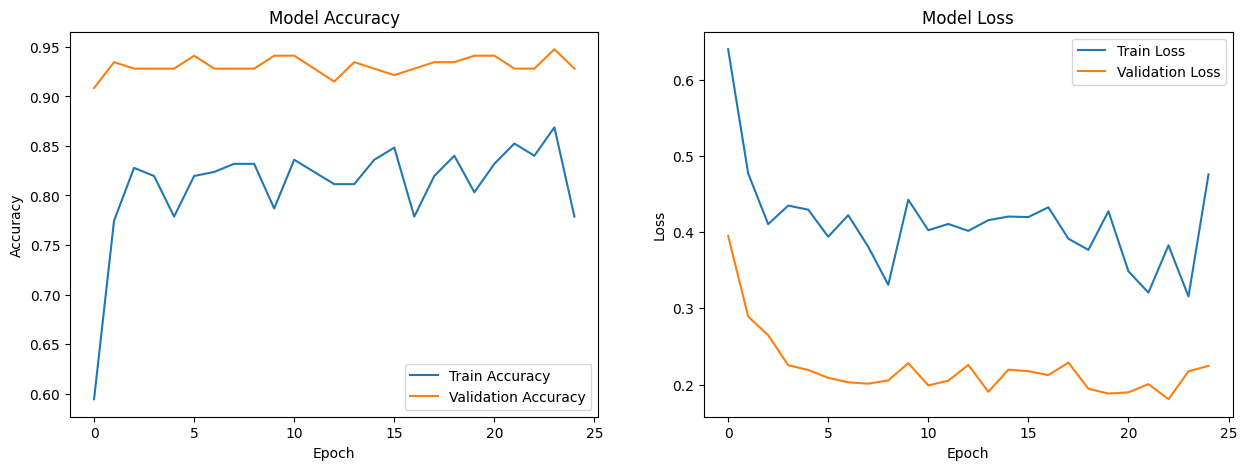

In [18]:
print(f"Plots Baseline")
plot_history(history_baseline)

print(f"Plots ResNet50")
plot_history(history_resnet50)

print(f"Plots GoogLeNet")
plot_history(history_googlenet)